In [2]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
def data_generation(n_samples=10000, n_features=5, random_state=42, noise_level=0.1):
    
    # Generate linearly separable data
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_features,
        n_redundant=0,
        n_clusters_per_class=1,
        flip_y=0,  # Controlled manually later
        class_sep=2.0,
        random_state=random_state
    )
    
    # Add bias column manually
    X = StandardScaler().fit_transform(X)
    bias = np.ones((X.shape[0], 1))
    x_values = np.hstack((bias, X))
    
    # Optionally add label noise
    y = y.astype(int)
    if noise_level > 0:
        num_noisy = int(noise_level * n_samples)
        noisy_indices = np.random.choice(n_samples, num_noisy, replace=False)
        y[noisy_indices] = 1 - y[noisy_indices]
    
    y_values = y.reshape(-1, 1)

    # Generate random beta just for reference
    beta_value = np.random.uniform(-1, 1, size=(n_features + 1, 1))
    
    return x_values, y_values, beta_value


In [4]:
X, Y, beta = data_generation(n_samples=10000, n_features=5, noise_level=0.1) 
print('X-array: \n',X)
print('\n Y-array: \n',Y)
print('\n Beta-array: \n',beta)

X-array: 
 [[ 1.         -0.61394193 -0.87202408  1.1942453  -1.1531219  -2.07276116]
 [ 1.         -0.88784775 -0.93324056  1.32852109  0.00491094 -0.5829326 ]
 [ 1.          0.0481465   1.74400715  0.85632477  1.66708662  0.78124597]
 ...
 [ 1.          0.4383003  -1.40681123 -0.39108481  0.63910028  1.04185668]
 [ 1.         -0.35789259 -1.32694314  0.27476517 -1.24432456 -0.63033783]
 [ 1.          1.49135111 -0.36610831 -0.67963055 -0.59596961  0.02865833]]

 Y-array: 
 [[1]
 [1]
 [1]
 ...
 [0]
 [1]
 [0]]

 Beta-array: 
 [[-0.86951045]
 [-0.71655249]
 [ 0.85969091]
 [ 0.45226808]
 [ 0.67344132]
 [-0.73406597]]


In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
x_train[:, 1:] = StandardScaler().fit_transform(x_train[:, 1:])
x_test[:, 1:] = StandardScaler().fit_transform(x_test[:, 1:])

In [6]:
def calculation(x_values, beta_value):
    y_values = []
    
    z_values = np.dot(x_values, beta_value)
    probs = 1/(1+np.exp(-z_values))
    
    for data in probs:
        y_values.append((data[0]>0.5).astype(int))
        
    return probs, np.array(y_values).reshape(-1,1)  


class LogisticRegression:
    def __init__(self, x_arr, true_values, coeff_,tau_,learning_rate,num_epochs, regularization_type):
        self.x_arr_original = x_arr.copy()
        self.true_values = true_values
        self.coeff_ = coeff_
        self.tau_ = tau_
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.regularization_type = regularization_type
        self.cost_values = []
        self.accuracy_values = []
    
    def initial_values(self):
        print(f"Initial Coefficients: {self.coeff_}")
        return None
    
    
    def training_model(self, epsilon=1e-9, lambda_=0.05):
        m = len(self.true_values)
        self.x_arr = self.x_arr_original.copy()
        self.x_arr[:, 1:] = StandardScaler().fit_transform(self.x_arr[:, 1:])

           
        
        for epoch in tqdm(range(self.num_epochs)):
          probs, predict_y = calculation(self.x_arr, self.coeff_)
          
          reg_coeff = self.coeff_.copy()
          reg_coeff[0] = 0
          
          if self.regularization_type == 'l1':
              loss_term = lambda_ * np.sum(np.abs(self.coeff_))
          elif self.regularization_type == 'l2':
              loss_term = lambda_ * np.sum(np.square(self.coeff_))
          elif self.regularization_type == 'l1 and l2':
              loss_term = lambda_ * (np.sum(np.abs(self.coeff_)) + np.sum(np.square(self.coeff_)))
          else:
              loss_term = 0            
              

          cost_function = -np.mean(
            self.true_values * np.log(probs + epsilon) +
            (1 - self.true_values) * np.log(1 - probs + epsilon)) + loss_term
        
          self.cost_values.append(cost_function) 

          # gradients
          error = probs - self.true_values
          d_coeff = np.dot(self.x_arr.T , error) /m
          
          # gradient regularization
          if self.regularization_type == 'l1':
            d_coeff += lambda_ * np.sign(self.coeff_)
          elif self.regularization_type == 'l2':
            d_coeff += 2 * lambda_ * self.coeff_
          elif self.regularization_type == 'l1 and l2':
            d_coeff += lambda_ * (np.sign(self.coeff_) + 2 * self.coeff_)  
          
          # update coefficients and intercept
          self.coeff_ -= self.learning_rate*d_coeff
          
          accuracy_metric = classification_report(self.true_values, predict_y, output_dict=True, zero_division=0).get('accuracy')
          self.accuracy_values.append(accuracy_metric) 
          
          if epoch%10==0 or epoch==self.num_epochs-1:
              print(f"Epoch {epoch}/{self.num_epochs}, Cost: {cost_function:.4f}, Accuracy: {accuracy_metric*100:.2f}%")
          
          if len(self.cost_values) > 1 and np.abs(self.cost_values[-1] - self.cost_values[-2]) <= self.tau_:
           print(f"Converged at epoch {epoch}")
           break
    
    def predict_function(self, x_values):
        x_scaled = x_values.copy()
        x_scaled[:, 1:] = StandardScaler().fit_transform(x_scaled[:, 1:])
        _, predict_y = calculation(x_scaled, self.coeff_)
        return predict_y
        

In [7]:
model = LogisticRegression(x_train, y_train, np.random.uniform(0,1,(X.shape[1],1)),0.0, 0.01, 2000, 'l1 and l2')
model.initial_values()

Initial Coefficients: [[0.05170163]
 [0.51555442]
 [0.75130185]
 [0.92827752]
 [0.24486661]
 [0.23755569]]


In [8]:
model.training_model()
print(f"\nFinal Coefficients: {model.coeff_}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0/2000, Cost: 0.9063, Accuracy: 61.18%
Epoch 10/2000, Cost: 0.8769, Accuracy: 62.85%
Epoch 20/2000, Cost: 0.8493, Accuracy: 64.58%
Epoch 30/2000, Cost: 0.8235, Accuracy: 66.27%
Epoch 40/2000, Cost: 0.7993, Accuracy: 68.05%
Epoch 50/2000, Cost: 0.7767, Accuracy: 69.33%
Epoch 60/2000, Cost: 0.7555, Accuracy: 70.92%
Epoch 70/2000, Cost: 0.7357, Accuracy: 72.55%
Epoch 80/2000, Cost: 0.7173, Accuracy: 74.13%
Epoch 90/2000, Cost: 0.7000, Accuracy: 75.55%
Epoch 100/2000, Cost: 0.6841, Accuracy: 77.28%
Epoch 110/2000, Cost: 0.6693, Accuracy: 78.68%
Epoch 120/2000, Cost: 0.6555, Accuracy: 80.07%
Epoch 130/2000, Cost: 0.6426, Accuracy: 81.22%
Epoch 140/2000, Cost: 0.6312, Accuracy: 82.32%
Epoch 150/2000, Cost: 0.6216, Accuracy: 83.20%
Epoch 160/2000, Cost: 0.6127, Accuracy: 83.90%
Epoch 170/2000, Cost: 0.6059, Accuracy: 84.55%
Epoch 180/2000, Cost: 0.6015, Accuracy: 85.18%
Epoch 190/2000, Cost: 0.5974, Accuracy: 85.65%
Epoch 200/2000, Cost: 0.5935, Accuracy: 86.08%
Epoch 210/2000, Cost: 0.

In [9]:
y_predict = model.predict_function(x_test)
print(f"Final Y data: {y_predict}")

Final Y data: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [1]]


In [10]:
result_dict={
    'Predicted': y_predict.flatten(),
    'True': y_test.flatten(),
}

print("Dataframe of predicted and true values")
pd.DataFrame(result_dict)

Dataframe of predicted and true values


,Predicted,True
0,0,0
1,0,0
2,0,0
3,1,1
4,0,1
...,...,...
3995,0,0
3996,0,0
3997,0,0
3998,0,0


## Result Analysis

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      2012
           1       0.86      0.91      0.88      1988

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



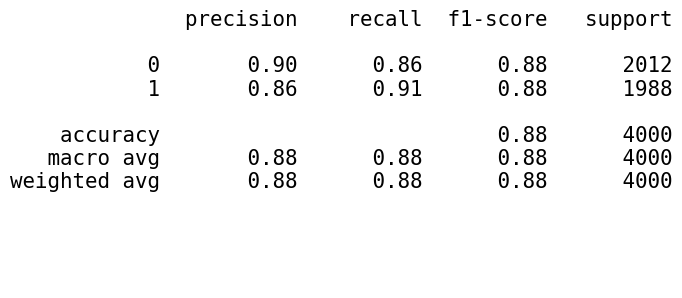

In [41]:
report = classification_report(y_test, y_predict)
print("Classification Report:\n", report)
plt.figure(figsize=(3,1))
plt.text(0, 1, report, {'fontsize': 15}, fontproperties='monospace') 
plt.axis('off')
plt.show()

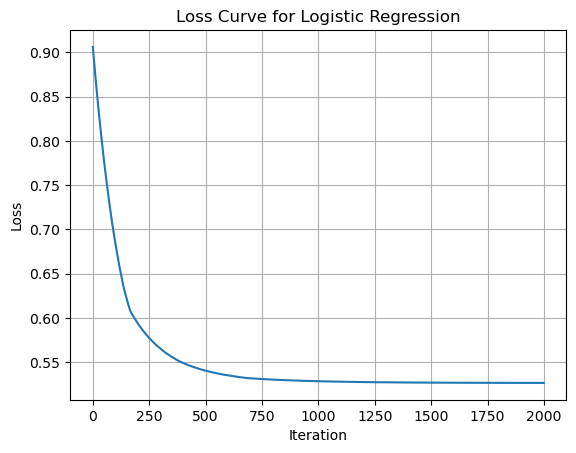

In [13]:
loss_list = model.cost_values

plt.plot(range(len(loss_list)), loss_list)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss Curve for Logistic Regression")
plt.grid(True)
plt.show()


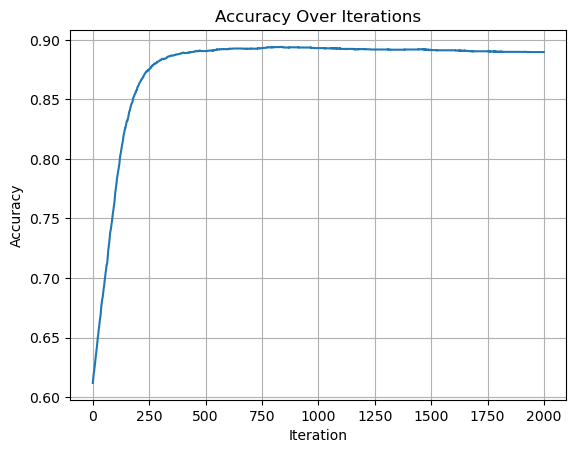

In [14]:
acc_list = model.accuracy_values

plt.plot(range(len(acc_list)), acc_list)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Iterations")
plt.grid(True)
plt.show()


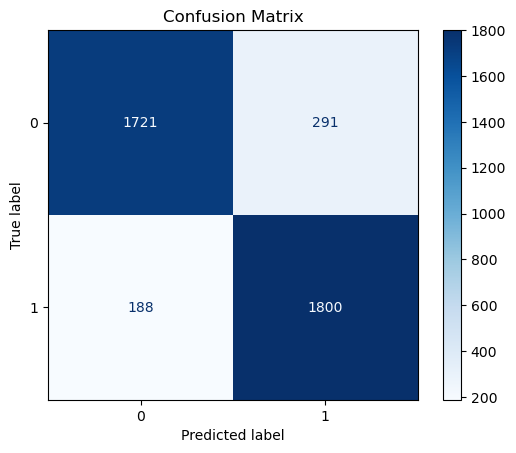

In [15]:
cm = confusion_matrix(y_test, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


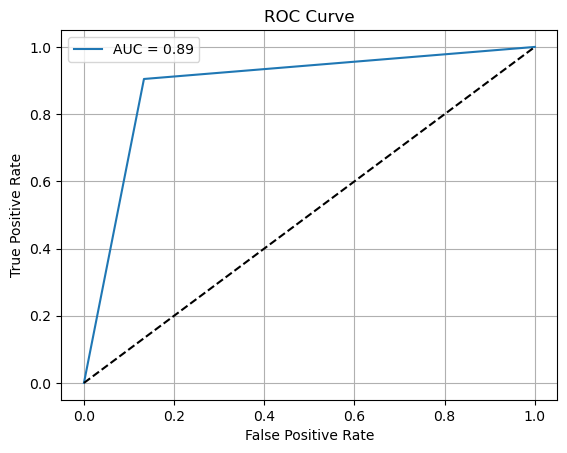

In [16]:
y_prob = model.predict_function(X)

fpr, tpr, _ = roc_curve(Y, y_prob)  # y_prob = model output (sigmoid)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()